In [2]:
# Adding utils' path
import sys
import os

sys.path.append(os.path.abspath('..'))

In [9]:
# Importing libraries
from tqdm import tqdm
import torch
from sklearn.preprocessing import LabelEncoder
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
)
from datasets import load_dataset, Dataset
from peft import LoraConfig, TaskType, get_peft_model
import evaluate
import numpy as np
import warnings
import random
import os
import json

from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Importing the arg parser
from BERT_utils import parse_args, gather_metrics, perform_lora_svd
from utils import plot_lora_svd_singular_values

# Suppress warnings
warnings.filterwarnings('ignore')

In [4]:
class Args:
    dataset = "arxiv"
    shuffle_label_ratio = 0
    train_num_classes = None
    use_lora = True
    lora_rank = 500
    lora_alpha, lora_dropout = 2*lora_rank, 0.1
    max_seq_length = 128
    batch_size, eval_batch_size, gradient_accumulation_steps, max_steps = 32, 50, 1, 500

args = Args()

In [6]:
# Dataset selection
if args.dataset == "arxiv":
    dataset = load_dataset("csv", data_files="../data/arxiv_filtered.csv")
    num_classes = 140
    label_column_name = "categories"
    text_column_name = "abstract"
else:
    raise ValueError("Currently not supported")

min_num_classes = 10

# Creating val/train split
dataset = dataset['train'].train_test_split(test_size=0.15, shuffle=True, seed=1)
train_dataset = dataset['train']
val_dataset = dataset['test']

Generating train split: 1996676 examples [00:33, 59323.63 examples/s]


In [ ]:
def clamp_dataset(dataset, num_classes, min_num_classes, label_column_name, text_column_name):
    # Count labels in the training and testing datasets
    label_counts = Counter(dataset[label_column_name])

    sorted_counts = sorted(label_counts.values())
    clamp_value = sum(sorted_counts[:min_num_classes])

    per_class_lim = sorted_counts[0] # Minimum counts per class

    # Group samples by class
    sample_by_class = {}
    for sample in tqdm(dataset, desc="Clamping"):
        cls = sample[label_column_name]
        if cls not in sample_by_class:
            sample_by_class[cls] = []

        if len(sample_by_class[cls]) < per_class_lim:
            sample_by_class[cls].append(sample)

    clamped_dataset = []
    for samples in sample_by_class.values():
        clamped_dataset += samples

    # Convert back to a Dataset format
    filtered_data = {
        text_column_name: [sample[text_column_name] for sample in clamped_dataset],
        label_column_name: [sample[label_column_name] for sample in clamped_dataset],
    }

    return Dataset.from_dict(filtered_data)

if args.train_num_classes:
    selected_classes = args.train_num_classes

    def filter_classes(batch):
        return batch[label_column_name] in selected_classes

    train_dataset = train_dataset.filter(filter_classes)
    val_dataset = val_dataset.filter(filter_classes)

    # Update num_classes to reflect the number of selected classes
    num_classes = len(selected_classes)

    # Preprocessing for the labels -> Once filtered the labels need to be set between (0, num(classes)-1)
    label_encoder = LabelEncoder()

    def label_preprocessing(dataset):
        # Fit the encoder only on the filtered labels
        label_encoder.fit(selected_classes)
        # Transform the dataset labels
        dataset = dataset.map(lambda batch: {label_column_name: label_encoder.transform([batch[label_column_name]])[0]})
        return dataset

    # Apply preprocessing
    train_dataset = label_preprocessing(train_dataset)
    val_dataset = label_preprocessing(val_dataset)

else:
    selected_classes = [i for i in range(num_classes)]

# Clamping train_dataset
train_dataset = clamp_dataset(train_dataset, num_classes, min_num_classes, label_column_name, text_column_name)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(batch):
    tokenized = tokenizer(
        batch[text_column_name],
        padding="max_length",
        truncation=True,
        max_length=args.max_seq_length
    )

    return tokenized

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Printing info
print(f"Length of dataset: {len(train_dataset)}")


In [7]:
# Shuffle labels if specified
def shuffle_labels(dataset, shuffle_fraction):
    num_samples = len(dataset)
    num_to_shuffle = int(num_samples * shuffle_fraction)
    print(f"Shuffling {num_to_shuffle}/{num_samples} labels.")

    if num_to_shuffle == 0:
        return dataset

    indices_to_shuffle = random.sample(range(num_samples), num_to_shuffle)
    shuffled_labels = [dataset[i][label_column_name] for i in indices_to_shuffle]
    random.shuffle(shuffled_labels)

    shuffled_dataset = []
    for i, sample in tqdm(enumerate(dataset), desc="Shuffling"):
        if i in indices_to_shuffle:
            sample[label_column_name] = shuffled_labels.pop(0)
        shuffled_dataset.append(sample)

    return Dataset.from_dict({key: [d[key] for d in shuffled_dataset] for key in dataset.column_names})

# Shuffle 'em labels in train
new_dataset = shuffle_labels(train_dataset, args.shuffle_label_ratio)

Shuffling 0/120680 labels.


In [41]:
# Preprocessing for the labels -> Only necessary for oxford-pet, not mnist or stanford-dogs
if args.dataset_type == "arxiv":
    label_encoder = LabelEncoder()

    def label_preprocessing(dataset):
        # Fit the encoder on the string labels and transform them to integer labels
        label_encoder.fit(dataset[label_column_name])
        encoded_labels = label_encoder.transform(dataset[label_column_name])

        # Add the encoded labels as a new column in the dataset
        return dataset.add_column('labels', encoded_labels)

    # Apply preprocessing
    train_dataset = label_preprocessing(train_dataset)
    val_dataset = label_preprocessing(val_dataset)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(train_dataset.unique(label_column_name))
)

# Apply LoRA
if args.use_lora:
    lora_config = LoraConfig(
        r=args.lora_rank,
        lora_alpha=args.lora_alpha,
        target_modules=["query", "key", "value"],  # BERT attention modules
        lora_dropout=args.lora_dropout,
        task_type=TaskType.SEQ_CLS,  # Task is sequence classification
    )
    model = get_peft_model(model, lora_config)

# Move model to GPU
model = model.to("cuda")

# Define evaluation metrics
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

In [44]:
run_name = f"BERT-{args.dataset_type}"
training_args = TrainingArguments(
    output_dir=f"results/{run_name}",
    per_device_train_batch_size=args.batch_size,
    per_device_eval_batch_size=args.eval_batch_size,
    # label_names = ['categories'],
    gradient_accumulation_steps=args.gradient_accumulation_steps,
    max_steps=args.max_steps,
    logging_steps=20,
    eval_steps=20,
    save_steps=20,
    save_total_limit=1,
    evaluation_strategy="steps",
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset.select(range(2000)),
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss,Accuracy
20,3.983100,4.123794,0.045000
40,4.079700,4.041208,0.043000
60,4.052400,4.009356,0.062500
80,4.015100,3.988956,0.048500
100,4.033400,3.982777,0.040000
120,3.939500,3.949215,0.044000
140,3.895300,3.949912,0.041000
160,3.900000,3.911591,0.044500
180,3.833200,3.890326,0.074500
200,3.807000,3.901281,0.072000


TrainOutput(global_step=500, training_loss=3.8472508239746093, metrics={'train_runtime': 868.2296, 'train_samples_per_second': 18.428, 'train_steps_per_second': 0.576, 'total_flos': 1394809798656000.0, 'train_loss': 3.8472508239746093, 'epoch': 0.1325556733828208})

In [45]:
def gather_metrics(trainer):
    """Given a tranformer trainer, return dictionary with training and validation loss
       as well as the accuracy."""

    log_history = trainer.state.log_history

    # Initialize lists for training and validation metrics
    steps = []
    training_loss = []
    validation_loss = []
    validation_accuracy = []

    # Extract relevant metrics
    for log in log_history:
        if 'loss' in log and 'step' in log:  # Training logs
            steps.append(log['step'])
            training_loss.append(log['loss'])
        elif 'eval_loss' in log and 'step' in log:  # Validation logs
            validation_loss.append(log['eval_loss'])
            validation_accuracy.append(log['eval_accuracy'])

    # Create a DataFrame
    data = {
        "Step": steps,
        "Training Loss": training_loss,
        "Validation Loss": validation_loss,
        "Validation Accuracy": validation_accuracy,
        "Best Results": {
            "Training Loss": min(training_loss),
            "Validation Loss": min(validation_loss),
            "Validation Accuracy": max(validation_accuracy),
        }
    }

    return data

def plot_metrics(data):
    """Given the dictionary of the results -> Plot the results"""
    # Create the figure and subplots
    fig, axes = plt.subplots(1, 2, figsize=(11, 5))

    # Plot training and validation loss
    axes[0].plot(data["Step"], data["Training Loss"], label="Training Loss", marker="o", color="blue")
    axes[0].plot(data["Step"], data["Validation Loss"], label="Validation Loss", marker="o", color="orange")
    axes[0].set_title("Loss Curves")
    axes[0].set_xlabel("Steps")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    # Plot validation accuracy
    axes[1].plot(data["Step"], data["Validation Accuracy"], label="Validation Accuracy", marker="o", color="green")
    axes[1].set_title("Validation Accuracy Curve")
    axes[1].set_xlabel("Steps")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(True)

    # Adjust layout and display
    plt.tight_layout()
    return plt.show()

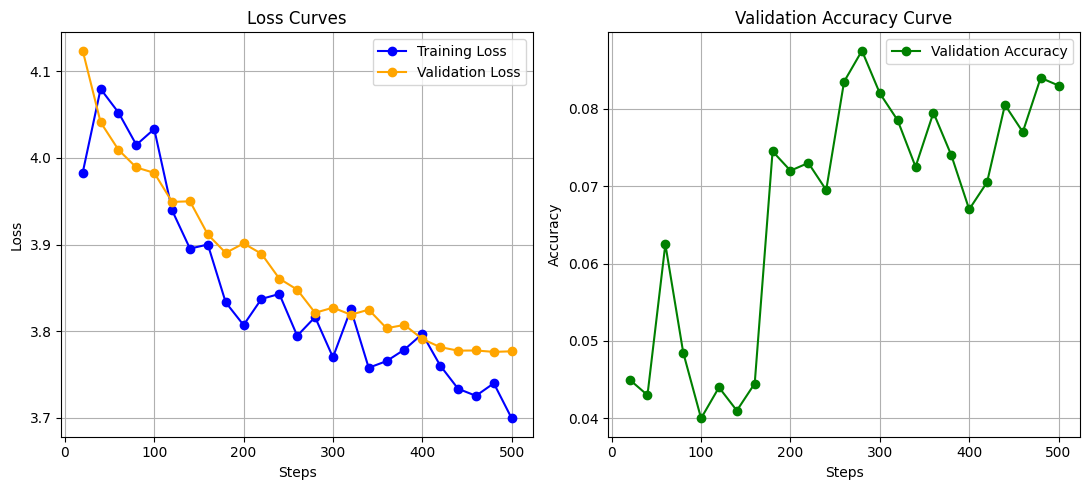

In [46]:
# Gather data from trainer and plot
data = gather_metrics(trainer)
plot_metrics(data)

Extracting LoRA SVD: 100%|██████████| 12/12 [00:07<00:00,  1.68it/s]


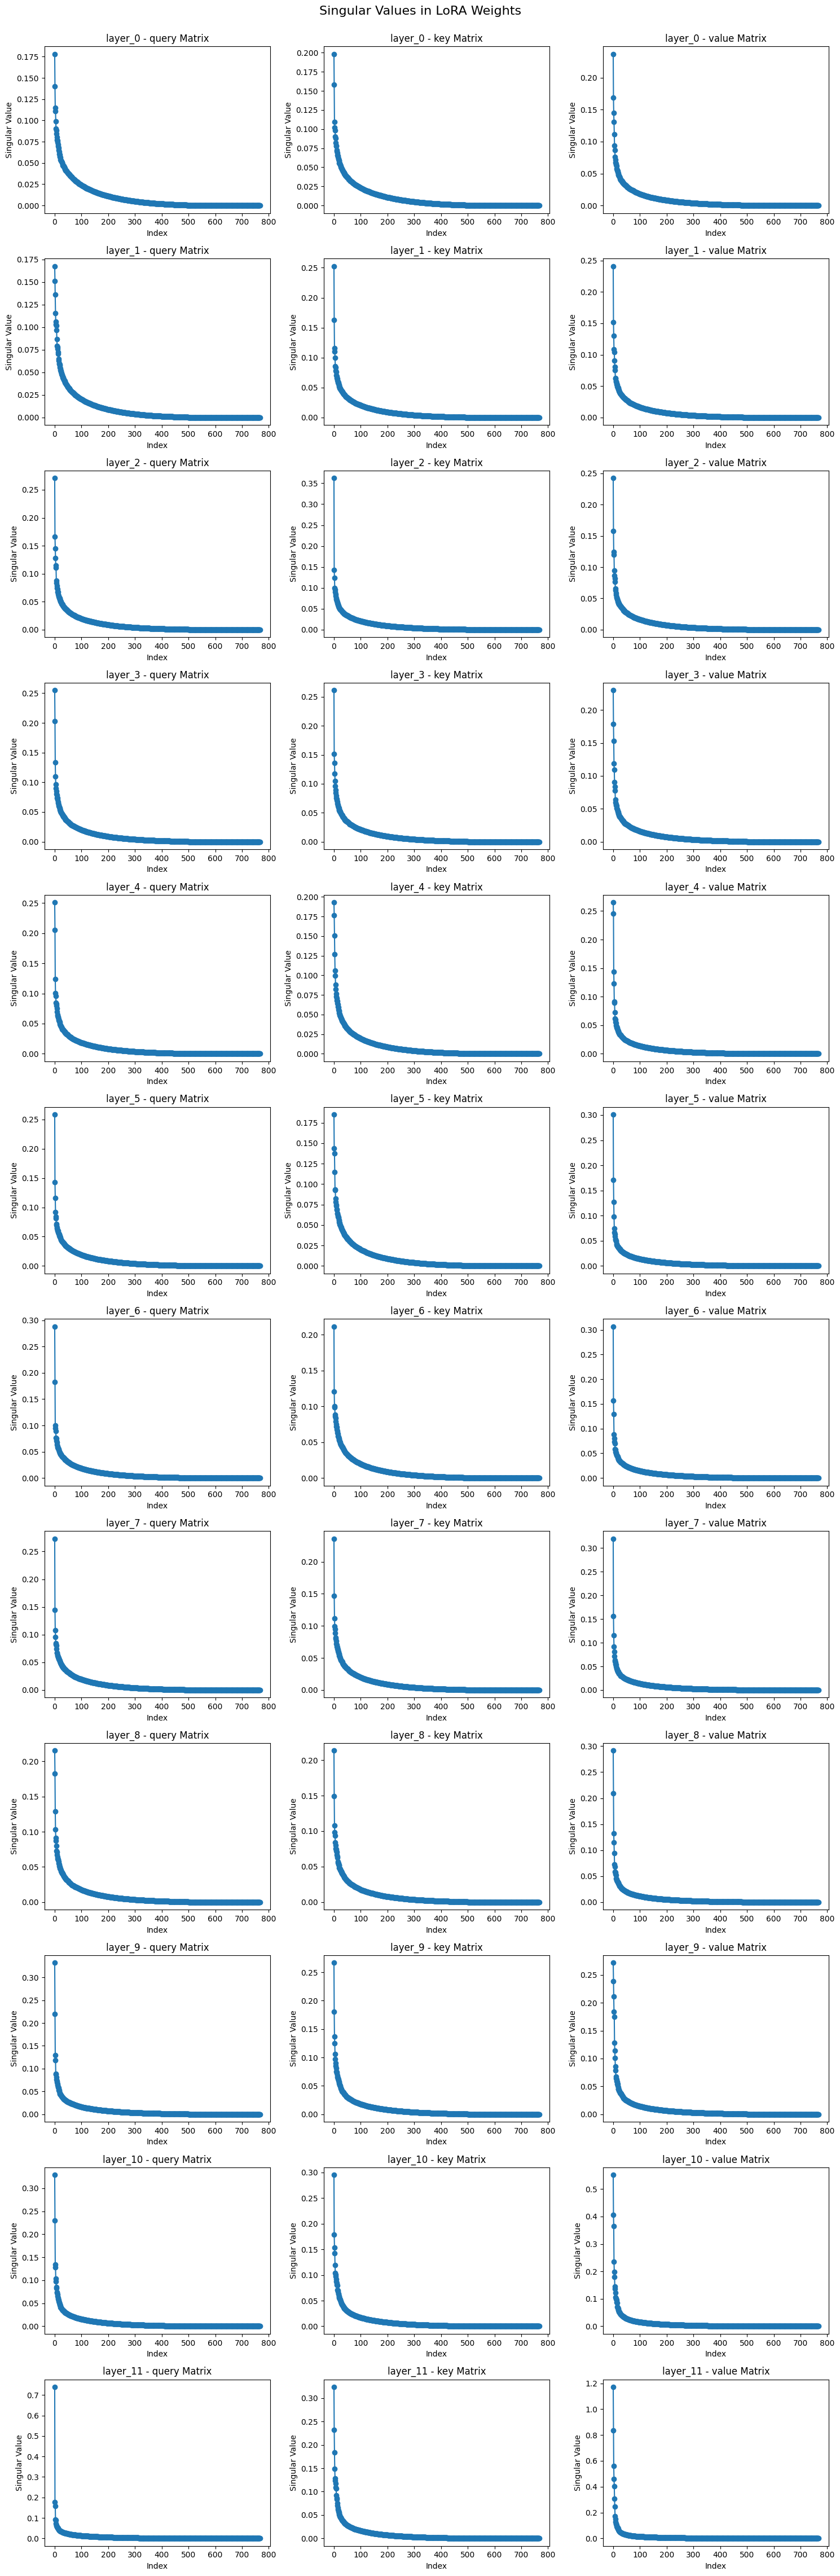

In [53]:
# If LoRA, then extract the diagonal entries for singular value decomposition
svd_diagonal_entries = perform_lora_svd(model)
plot_lora_svd_singular_values(svd_diagonal_entries)